<a href="https://colab.research.google.com/github/aparnashenoy/ml/blob/master/knn_imputation_rf_alg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [37]:
path = '/gdrive/My Drive/'

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [39]:
data = pd.read_csv(path + 'Copy of train.psv', sep='|')

In [40]:
data.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,99.0,100.0,NaN,NaN,71.0,NaN,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.66,0,1.0,0.0,-0.02,2,0
1,97.5,100.0,NaN,NaN,NaN,NaN,15.0,NaN,-16.0,16.0,NaN,7.19,25.0,NaN,72.5,13.5,58.0,8.1,112.5,1.7,NaN,73.0,8.6,1.75,3.2,4.4,3.65,NaN,26.9,8.35,74.4,15.65,104.0,93.0,69.66,0,1.0,0.0,-0.02,3,0
2,96.0,100.0,NaN,NaN,70.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.66,0,1.0,0.0,-0.02,4,0
3,100.0,99.0,NaN,NaN,75.0,NaN,14.0,NaN,-15.0,11.0,NaN,7.24,24.0,96.0,NaN,12.0,NaN,7.7,113.0,1.6,NaN,85.0,8.9,1.60,2.9,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.66,0,1.0,0.0,-0.02,5,0
4,102.0,100.0,36.0,NaN,74.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.66,0,1.0,0.0,-0.02,6,0


In [41]:
data.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [42]:
cols = ['HR', 'O2Sat','Temp', 'SBP', 'MAP', 'DBP', 'Resp','Age', 'Gender', 'Unit1', 'Unit2', 'ICULOS', 'SepsisLabel']

In [43]:
data = data[cols]

In [44]:
data.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Age,Gender,Unit1,Unit2,ICULOS,SepsisLabel
0,99.0,100.0,NaN,NaN,71.0,NaN,13.5,69.66,0,1.0,0.0,2,0
1,97.5,100.0,NaN,NaN,NaN,NaN,15.0,69.66,0,1.0,0.0,3,0
2,96.0,100.0,NaN,NaN,70.0,NaN,13.0,69.66,0,1.0,0.0,4,0
3,100.0,99.0,NaN,NaN,75.0,NaN,14.0,69.66,0,1.0,0.0,5,0
4,102.0,100.0,36.0,NaN,74.0,NaN,17.0,69.66,0,1.0,0.0,6,0


In [45]:
missing_count = data.isnull().sum().sort_values(ascending = True)

In [46]:
missing_count

Age                 0
Gender              0
ICULOS              0
SepsisLabel         0
HR             107735
MAP            137670
O2Sat          149329
Resp           157166
SBP            173917
DBP            434103
Unit1          495981
Unit2          495981
Temp           772577
dtype: int64

In [47]:
missing_percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)

In [48]:
missing_percent

Temp           66.190514
Unit2          42.493159
Unit1          42.493159
DBP            37.191763
SBP            14.900334
Resp           13.465193
O2Sat          12.793758
MAP            11.794874
HR              9.230193
SepsisLabel     0.000000
ICULOS          0.000000
Gender          0.000000
Age             0.000000
dtype: float64

In [49]:
missing_data = pd.concat([missing_count, missing_percent], axis=1, keys=['missing_count', 'missing_percent'])

In [50]:
missing_data

,missing_count,missing_percent
Age,0,0.000000
Gender,0,0.000000
ICULOS,0,0.000000
SepsisLabel,0,0.000000
HR,107735,9.230193
MAP,137670,11.794874
O2Sat,149329,12.793758
Resp,157166,13.465193
SBP,173917,14.900334
DBP,434103,37.191763


In [51]:
#plt.figure(figsize=(16, 6))
#sns.heatmap(data.isnull())

In [52]:
categorical = data.dtypes == object
categorical['Unit1'] = True
categorical['Unit2'] = True
categorical['Gender'] = True

In [53]:
cat_var = list(categorical[categorical].index)
cont_var = list(categorical[~categorical].index)
cont_var.pop(-1)

'SepsisLabel'

In [54]:
data = data.sample(n=100000, random_state=None)

In [55]:
#from pylab import rcParams

In [56]:
#rcParams['figure.figsize'] = 5, 5
#for i,var in enumerate(cont_var):
    #plt.figure(i)
    #plt.title("Density plot of " + str(var))
    #sns.distplot(data[var].dropna(), axlabel=var);

In [57]:
#plt.figure(figsize=(12, 6))
#sns.set_style('whitegrid')
#ax=sns.countplot(x='SepsisLabel', data= data)
#for p in ax.patches:
    #ax.annotate(format(p.get_height(), '.1f'), 
                   #(p.get_x() + p.get_width() / 2., p.get_height()), 
                   #ha = 'center', va = 'center', 
                   #xytext = (0, 9), 
                   #textcoords = 'offset points')

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

In [59]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
data.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Age,Gender,Unit1,Unit2,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.522558,1.0,1.0,0.0,0.092537,0.0
1,0.167308,0.98750,NaN,0.390099,0.160714,0.097122,0.135417,0.789884,1.0,0.0,1.0,0.017910,0.0
2,0.242308,0.95000,NaN,0.344554,0.171429,0.104317,0.177083,0.804070,1.0,NaN,NaN,0.104478,0.0
3,NaN,0.98750,0.745139,0.316832,0.182143,0.118705,0.135417,0.478023,0.0,1.0,0.0,0.083582,0.0
4,0.269231,0.94375,0.736111,0.253465,0.092857,NaN,0.140625,0.740930,0.0,0.0,1.0,0.152239,0.0


In [60]:
#imputer = KNNImputer(n_neighbors=3)
#imputed = imputer.fit_transform(data)
#data_imputed = pd.DataFrame(imputed, columns=data.columns)

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

In [62]:
#def optimize_k(data, target):
    #errors = []
    #for k in range(1, 50, 2):
        #imputer = KNNImputer(n_neighbors=k)
        #imputed = imputer.fit_transform(data)
        #data_imputed = pd.DataFrame(imputed, columns=data.columns)
        
        #X = data_imputed.drop('SepsisLabel', axis=1)
        #y = data_imputed['SepsisLabel']
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        #model = RandomForestClassifier()
        #model.fit(X_train, y_train)
        #preds = model.predict(X_test)
        #error = rmse(y_test, preds)
        #errors.append({'K': k, 'RMSE': error})
        
    #return errors

In [63]:
#k_errors = optimize_k(data=data, target='SepsisLabel')

In [64]:
#print(k_errors)

In [65]:
#k_errors

In [66]:
#data.isna().sum()

In [67]:
imputer = KNNImputer(n_neighbors=15)
imputed = imputer.fit_transform(data)
data_imputed = pd.DataFrame(imputed, columns=data.columns)

In [68]:
data_imputed.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Age,Gender,Unit1,Unit2,ICULOS,SepsisLabel
0,0.240385,0.96375,0.724630,0.412937,0.231350,0.158513,0.181597,0.522558,1.0,1.000000,0.000000,0.092537,0.0
1,0.167308,0.98750,0.694398,0.390099,0.160714,0.097122,0.135417,0.789884,1.0,0.000000,1.000000,0.017910,0.0
2,0.242308,0.95000,0.732778,0.344554,0.171429,0.104317,0.177083,0.804070,1.0,0.733333,0.266667,0.104478,0.0
3,0.249487,0.98750,0.745139,0.316832,0.182143,0.118705,0.135417,0.478023,0.0,1.000000,0.000000,0.083582,0.0
4,0.269231,0.94375,0.736111,0.253465,0.092857,0.091367,0.140625,0.740930,0.0,0.000000,1.000000,0.152239,0.0


In [69]:

X = data_imputed.drop('SepsisLabel', axis=1)
y = data_imputed['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     19623
         1.0       0.85      0.03      0.06       377

    accuracy                           0.98     20000
   macro avg       0.91      0.51      0.52     20000
weighted avg       0.98      0.98      0.97     20000



In [72]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, preds)
print(cf_matrix)

[[19621     2]
 [  366    11]]


In [73]:
rf_probs = model.predict_proba(X_test)

In [74]:
rf_probs = rf_probs[:, 1]

In [75]:
from sklearn.metrics import roc_auc_score

# calculate scores
rf_auc = roc_auc_score(y_test, rf_probs)


print('Random Forest: ROC AUC= {} %'.format(round(rf_auc, 3)*100))

Random Forest: ROC AUC= 83.39999999999999 %


In [76]:
from imblearn.over_sampling import SMOTE

smote = SMOTE( random_state= 0 )

In [77]:
X_smote, y_smote = smote.fit_resample(X_train, y_train)
X_smote.shape, y_smote.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((156868, 12), (156868,))

In [78]:
X_smote_test, y_smote_test = smote.fit_resample(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [79]:
model_smote = RandomForestClassifier()
model_smote.fit(X_smote, y_smote)
preds_smote = model_smote.predict(X_smote_test)

In [81]:
print(classification_report(y_smote_test, preds_smote))

              precision    recall  f1-score   support

         0.0       0.67      0.99      0.79     19623
         1.0       0.97      0.50      0.66     19623

    accuracy                           0.75     39246
   macro avg       0.82      0.75      0.73     39246
weighted avg       0.82      0.75      0.73     39246



In [82]:
cf_matrix_smote = confusion_matrix(y_smote_test, preds_smote)
print(cf_matrix_smote)

[[19348   275]
 [ 9714  9909]]


In [83]:
rf_probs_smote = model.predict_proba(X_smote_test)

In [84]:
rf_probs_smote = rf_probs_smote[:, 1]

In [86]:
from sklearn.metrics import roc_auc_score

# calculate scores
rf_smote_auc = roc_auc_score(y_smote_test, rf_probs_smote)


print('Random Forest_smote: ROC AUC= {} %'.format(round(rf_smote_auc, 3)*100))

Random Forest_smote: ROC AUC= 79.4 %


In [102]:
from sklearn.metrics import roc_curve

In [103]:
rf_fpr, rf_tpr, rf_thres = roc_curve(y_smote_test, rf_probs_smote)

In [87]:
data_imputed.to_csv(path+'data_imputed.csv')

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [89]:
fold = StratifiedKFold(n_splits=5, random_state=1, shuffle = True)
fold.get_n_splits(X_smote, y_smote)

5

In [90]:
parameters = {'solver':('newton-cg', 'liblinear'), 'C':[0.001]}

model = LogisticRegression(penalty='l2', n_jobs = -2, max_iter=1000)
log_reg = GridSearchCV(model, parameters, n_jobs= -2, cv=fold)

log_reg.fit(X_smote, y_smote)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=-2, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-2,
             param_grid={'C': [0.001], 'solver': ('newton-cg', 'liblinear')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [91]:
yt_pred_log_reg = log_reg.predict(X_smote_test)
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_smote_test, yt_pred_log_reg ))

ac= accuracy_score(y_smote_test, yt_pred_log_reg)
print('test_accuracy = {} % '.format(ac * 100))

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67     19623
         1.0       0.67      0.67      0.67     19623

    accuracy                           0.67     39246
   macro avg       0.67      0.67      0.67     39246
weighted avg       0.67      0.67      0.67     39246

test_accuracy = 66.91127758242878 % 


In [92]:
cf_matrix = confusion_matrix(y_smote_test, yt_pred_log_reg)
print(cf_matrix)

[[13112  6511]
 [ 6475 13148]]


In [107]:
logreg_probs = log_reg.predict_proba(X_smote_test)

In [108]:
logreg_probs = logreg_probs[:, 1]

In [110]:
logreg_auc = roc_auc_score(y_smote_test, logreg_probs)

In [111]:
print('Logistic: ROC AUC= {} %'.format(round(logreg_auc, 3)*100))

Logistic: ROC AUC= 72.5 %


In [112]:
from sklearn.metrics import roc_curve
#fpr --> False Positive Rate
#tpr --> True Positive Rate
logreg_fpr, logreg_tpr, lr_thres = roc_curve(y_smote_test, logreg_probs)

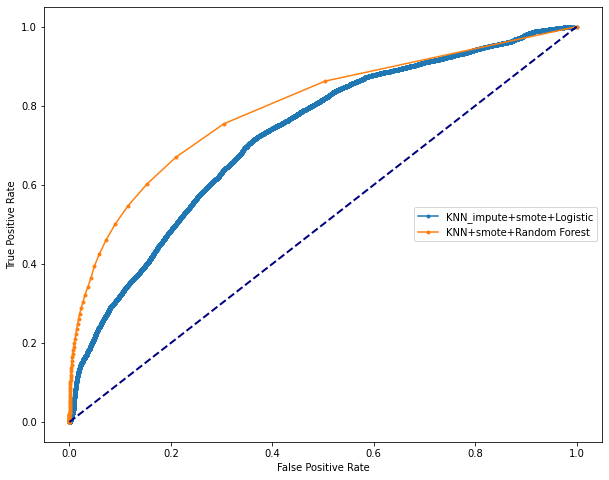

In [114]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(logreg_fpr, logreg_tpr, marker='.', label='KNN_impute+smote+Logistic')
ax.plot(rf_fpr, rf_tpr, marker='.', label='KNN+smote+Random Forest')
lw = 2
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc=5)
# show the plot
plt.show()

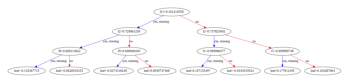

<Figure size 3600x3960 with 0 Axes>

In [93]:
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
model = XGBClassifier()

# Train
model.fit(X_smote, y_smote)

plot_tree(model)
plt.figure(figsize = (50,55))
plt.show()

In [94]:
y_pred_xgb= model.predict(X_smote_test)

from sklearn.metrics import classification_report
print(classification_report(y_smote_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89     19623
         1.0       0.90      0.88      0.89     19623

    accuracy                           0.89     39246
   macro avg       0.89      0.89      0.89     39246
weighted avg       0.89      0.89      0.89     39246



In [100]:
cf_matrix = confusion_matrix(y_smote_test, y_pred_xgb)
print(cf_matrix)

[[17696  1927]
 [ 2421 17202]]


In [95]:
model_probs = model.predict_proba(X_smote_test)
model_probs = model_probs[:, 1]
model_auc = roc_auc_score(y_smote_test, model_probs)

print('XGBoost - ROC AUC= {} %'.format(round(model_auc, 3)*100))

XGBoost - ROC AUC= 95.5 %


In [117]:
model_fpr, model_tpr, model_thres = roc_curve(y_smote_test, model_probs)

In [96]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_smote, y_smote)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [97]:
y_pred_clf= clf.predict(X_smote_test)

from sklearn.metrics import classification_report
print(classification_report(y_smote_test, y_pred_clf))

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86     19623
         1.0       0.87      0.85      0.86     19623

    accuracy                           0.86     39246
   macro avg       0.86      0.86      0.86     39246
weighted avg       0.86      0.86      0.86     39246



In [98]:
cf_matrix = confusion_matrix(y_smote_test, y_pred_clf)
print(cf_matrix)

[[17062  2561]
 [ 3025 16598]]


In [101]:
clf_probs = clf.predict_proba(X_smote_test)
clf_probs = clf_probs[:, 1]
clf_auc = roc_auc_score(y_smote_test, clf_probs)

print('ADABOOST - ROC AUC= {} %'.format(round(clf_auc, 3)*100))

ADABOOST - ROC AUC= 93.2 %


In [115]:
clf_fpr, clf_tpr, clf_thres = roc_curve(y_smote_test, clf_probs)

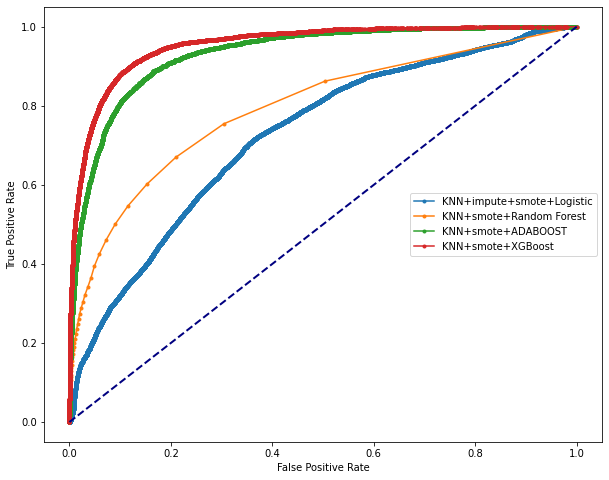

In [118]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(logreg_fpr, logreg_tpr, marker='.', label='KNN+impute+smote+Logistic')
ax.plot(rf_fpr, rf_tpr, marker='.', label='KNN+smote+Random Forest')
ax.plot(clf_fpr, clf_tpr, marker='.', label='KNN+smote+ADABOOST')
ax.plot(model_fpr, model_tpr, marker = '.', label='KNN+smote+XGBoost')
lw = 2
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc=5)
# show the plot
plt.show()

In [119]:
print('Logistic: ROC AUC= {} %'.format(round(logreg_auc, 3)*100))
print('RF - ROC AUC= {} %'.format(round(rf_auc, 3)*100))
print('ADABOOST - ROC AUC= {} %'.format(round(clf_auc, 3)*100))
print('XGBoost - ROC AUC= {} %'.format(round(model_auc, 3)*100))

Logistic: ROC AUC= 72.5 %
RF - ROC AUC= 83.39999999999999 %
ADABOOST - ROC AUC= 93.2 %
XGBoost - ROC AUC= 95.5 %
